In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyhacores.utils import *
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

In [3]:
from pyhacores.cordic import NCO
import inspect
print(inspect.getdoc(NCO))

Baseband signal generator. Integrated phase accumulator.


# Applications

## IQ generator

In [4]:
period = 2
fs = 1024
freq = 200
phase_inc = 2 * np.pi * freq / fs
phase_cumsum = np.arange(0, period * fs * phase_inc, phase_inc)
input_signal = np.diff(phase_cumsum) / np.pi

In [5]:
dut = NCO(cordic_iterations=14)
sims = simulate(dut, input_signal, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 2064/2064 [00:01<00:00, 1911.24it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [6]:
assert sims_close(sims, rtol=1e-2, atol=1e-4)

INFO:sim:sims_close(rtol=0.01, atol=0.0001)
INFO:sim:Using "MODEL" as golden output
INFO:sim:MODEL OK!
INFO:sim:PYHA OK!


In [7]:
print(f"SNR: {snr(sims['MODEL'], sims['PYHA'])} dB")

SNR: 81.355650277832 dB


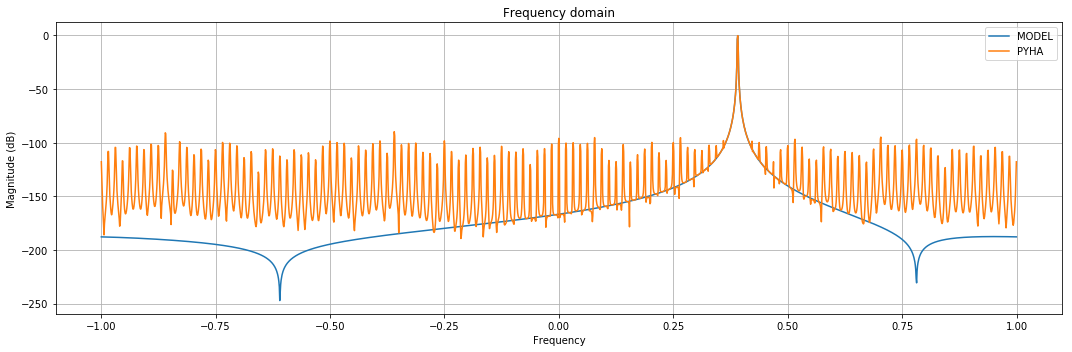

In [8]:
plt.title('Frequency domain')
for key, value in sims.items():
    plt.magnitude_spectrum(value, scale='dB', label=key)
show_plot()

## Other applications
This core can be used to implement phase/amplitude modulators. This will be covered on the documentation of those cores.

# Limitations

## Fixed-point
Expects standard FPGA Fixed point format i.e 18 bits (incl. sign) and scaled to -1...1 range.

In [9]:
print(f'Minimum number representabe: {2**-17}')

Minimum number representabe: 7.62939453125e-06


# Synthesis

In [10]:
# NBVAL_IGNORE_OUTPUT
output_dir = '/tmp/pyha_output'
sims = simulate(dut, input_signal, simulations=['PYHA', 'GATE'], conversion_path=output_dir)

INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 2064/2064 [00:03<00:00, 604.68it/s]

INFO:sim:OK!
INFO:sim:Running "GATE" simulation...
INFO:conversion:Creating top.vhd ...


INFO:conversion:Cordic to VHDL ...
INFO:conversion:NCO to VHDL ...
INFO:sim:Running quartus map...will take time.
INFO:sim:Analysis & Synthesis Status : Successful - Thu Aug  2 11:08:46 2018
INFO:sim:Quartus Prime Version : 17.1.0 Build 590 10/25/2017 SJ Lite Edition
INFO:sim:Revision Name : quartus_project
INFO:sim:Top-level Entity Name : top
INFO:sim:Family : Cyclone IV E
INFO:sim:Total logic elements : 1,303
INFO:sim:    Total combinational functions : 1,262
INFO:sim:    Dedicated logic registers : 828
INFO:sim:Total registers : 828
INFO:sim:Total pins : 56
INFO:sim:Total virtual pins : 0
INFO:sim:Total memory bits : 0
INFO:sim:Embedded Multiplier 9-bit elements : 0
INFO:sim:Total PLLs : 0
INFO:sim:Running netlist writer.
INFO:sim:Running COCOTB & GHDL simulation....
INFO:sim:VHDL stderr: 
    loading VPI module '/home/gaspar/git/pyha/cocotb/build/libs/x86_64/libvpi.so'
    VPI module loaded!
INFO:sim:OK!
INFO:sim:Simulations completed!


In [11]:
assert hardware_sims_equal(sims)

INFO:sim:Testing hardware simulations equality...
INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "PYHA" as golden output
INFO:sim:PYHA OK!
INFO:sim:GATE OK!


In [12]:
from pyha.simulation.vhdl_simulation import VHDLSimulation
print(f'Logic elements: {VHDLSimulation.last_logic_elements}')
print(f'Memory: {VHDLSimulation.last_memory_bits}')
print(f'Multipler (18bit): {VHDLSimulation.last_multiplier//2}')

Logic elements: 1303
Memory: 0
Multipler (18bit): 0
